# QAOA

## MAXCUT

### Definitions

In [1]:
#%%writefile '02_Eigenvalues.py'
# Import NumPy
import numpy as np
# Import scipy optimization
import scipy as sp
# Import mathplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
# Import pandas
import pandas as pd
# Import networkx
import networkx as nx
# Import Qiskit
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA,\
                                         GradientDescent
from qiskit.algorithms import VQE, NumPyEigensolver
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, One, ListOp,\
                          PauliExpectation, PauliTrotterEvolution,\
                          CircuitSampler, MatrixEvolution, Suzuki,\
                          StateFn, Plus, Minus, DictStateFn,\
                          VectorStateFn, CircuitStateFn, AerPauliExpectation,\
                          OperatorStateFn, MatrixOp, ExpectationFactory
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer, execute
from qiskit.circuit.library import RealAmplitudes, TwoLocal, RZZGate
from qiskit.circuit import ParameterVector, Parameter
from qiskit import QuantumCircuit,  ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info.operators import Operator, Pauli
from scipy.optimize import minimize
from qiskit.providers.aer import AerError
from qiskit.providers.aer.noise import NoiseModel
import random

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from tqdm import trange, tqdm_notebook

In [4]:
def pd_process(data_df):
    res_proc = pd.DataFrame({'mean': data_df.mean(axis = 1),\
                           'std': data_df.std(axis = 1),\
                           'sem': data_df.sem(axis = 1)})
    return res_proc

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Sans Serif"],
})

In [7]:
# Initialize a GPU backend
try:
    backend = Aer.get_backend('aer_simulator')
    backend.set_options(method="density_matrix", device='GPU')
    print('Successfully set GPU simulator')
except AerError as e:
    backend = Aer.get_backend('aer_simulator')
    print('Error initialising GPU, using CPU simulator instead')

Successfully set GPU simulator


In [6]:
backend = Aer.get_backend('statevector_simulator')

In [7]:
print(backend)

statevector_simulator


Generate training set

In [8]:
NUMBER = 6
A = 11
INDEX = 11

In [134]:
# Generate training set randomly.
# NUMBER elements are generated in square with side length 2*A
# first INDEX of elements are shifted by A to the right while other are shifted to the left
def get_float_list(start, stop, size):
    result = []
    unique_set = set()
    for i in range(size):
        x = round(random.uniform(start, stop),2)
        while x in unique_set:
            x = round(random.uniform(start, stop),2)
        unique_set.add(x)
        result.append(x)
    return result
X = get_float_list(-A,A,NUMBER)
Y = get_float_list(-A,A,NUMBER)
for i in range(len(X)):
    if i < INDEX:
        X[i] = X[i] + A
    else:
        X[i] = X[i] - A
X = np.array(X)
Y = np.array(Y)

In [101]:
np.savetxt('dataset_x.txt', X)
np.savetxt('dataset_y.txt', Y)

or decide to load existing dataset

In [9]:
X = np.loadtxt('dataset_x.txt')
Y = np.loadtxt('dataset_y.txt')

<IPython.core.display.Javascript object>


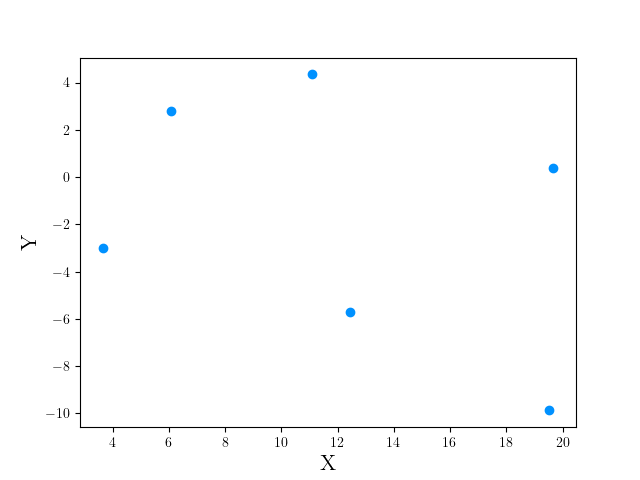

In [10]:
fig, ax = plt.subplots()
ax.scatter(x = X, y = Y,\
            color='#0091FF',\
            figure = fig)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('training_set.pdf')

In [11]:
P = []
for i in range(len(X)):
    P.append(np.array([X[i], Y[i]]))
P = np.array(P)

In [12]:
def dist_matrix(p_list):
    C = np.zeros((NUMBER, NUMBER))
    for i in range(NUMBER):
        for j in range(NUMBER):
            C[i][j] = np.linalg.norm(p_list[i]-p_list[j])
    max = C.max()
    for i in range(NUMBER):
        for j in range(NUMBER):
            C[i][j] = round(2 * np.pi * (C[i][j]) / max, 2)
    return C

In [13]:
C = dist_matrix(P)

In [14]:
print(C)

[[0.   6.28 4.7  3.61 2.14 1.78]
 [6.28 0.   3.49 2.79 5.88 5.62]
 [4.7  3.49 0.   3.21 5.57 3.22]
 [3.61 2.79 3.21 0.   3.13 3.45]
 [2.14 5.88 5.57 3.13 0.   3.55]
 [1.78 5.62 3.22 3.45 3.55 0.  ]]


In [15]:
# Cost function (is minimized)
def cost_fun(bitstring, c_mat):
    cost = 0
    for i in range(len(bitstring)):
        for j in range(i+1, len(bitstring)):
            if bitstring[i] != bitstring[j]:
                # Minimization: lower cost = better
                cost -= c_mat[i][j]
    return cost

brute force solver

In [16]:
def brute_force(nelements,c_mat):
    def genbin(n, array, bs = '',):
        if n:
            genbin(n-1, array, bs + '0')
            genbin(n-1, array, bs + '1')
        else:
            array.append(bs)
    ar  = []
    genbin(nelements,ar)
    cost_ar = []
    for bs in ar:
        cost_ar.append(cost_fun(bs, c_mat))
    cost_ar = np.array(cost_ar)
    index = np.argmin(cost_ar)
    print('optimal bs', ar[index], ' with value', cost_ar[index])
    return ar[index], cost_ar[index]

In [17]:
bs, cost = brute_force(NUMBER, C)

optimal bs 011100  with value -41.46000000000001


In [18]:
print(cost_fun('001110',C))

-32.83


In [19]:
X_blue = []
Y_blue = []
X_orange = []
Y_orange = []
for it in range(len(bs)):
    if (bs[it] == '0'):
        X_blue.append(X[it])
        Y_blue.append(Y[it])
    else:
        X_orange.append(X[it])
        Y_orange.append(Y[it])

<IPython.core.display.Javascript object>


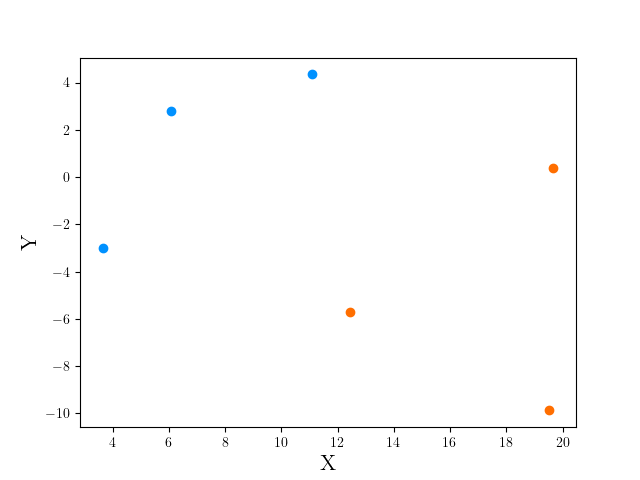

In [20]:
fig, ax = plt.subplots()
ax.scatter(x = X_blue, y = Y_blue,\
            color='#0091FF',\
            figure = fig)
ax.scatter(x = X_orange, y = Y_orange,\
            color='#FF6e00',\
            figure = fig)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
plt.savefig('clustered_set.pdf')

Quantum solver

In [21]:
# Basic implemenation of the simple gradient descent 
def gradient_descent(GRADIENT_FUN, INITIAL, ETA, MAX_ITER=100, EPSILON=0.01):
    vector = np.array(INITIAL)
    learning_rate = ETA
    step_init = 0.05
    step = step_init
    loops = 0
    last_three = [0,0,0]
    LEN = len(INITIAL)
    for i in range(0, MAX_ITER):
        GRAD, value = GRADIENT_FUN(vector, step)
        last_three[loops%3] = value
        diff = - learning_rate * np.array(GRAD)
        if (np.std(np.array(last_three)) <= EPSILON):
            break
        vector += diff
        #for index in range(0, len(vector)):
        #    if np.abs(vector[index]) > 3.15/2:
        #        vector[index] /= 2
        step = np.min([(np.abs(np.array(diff)).sum()/LEN)/2, step_init])
        loops += 1
        #print(vector)
    return vector.tolist(), loops

#RMSProp
def RMSProp(GRADIENT_FUN, INITIAL, ETA, GAM, MAX_ITER=100, EPSILON=0.01, log=False):
    if log:
        X_pos = []
        Y_pos = []
    last_three = [0,0,0]
    vector = np.array(INITIAL)
    learning_rate = ETA
    avg_par = GAM
    step = 0.05
    loops = 0
    e_small = 0.01
    LEN = len(INITIAL)
    E = []
    for j in range(0,LEN):
        E.append(0)
    for i in trange(0, MAX_ITER):
        if log:
            X_pos.append(vector[0])
            Y_pos.append(vector[1])
        gradient, value = GRADIENT_FUN(vector, step)
        last_three[loops%3] = value
        diff = []
        for j in range(0, LEN):
            E[j] = avg_par * E[j] + (1-avg_par)*(gradient[j]**2)
            diff.append(- (learning_rate/(np.sqrt(E[j])+e_small)) * gradient[j])
        if (np.std(np.array(last_three)) <= EPSILON):
            break
        vector += diff
        #for index in range(0, len(vector)):
        #    if np.abs(vector[index]) > 3.15/2:
        #        vector[index] /= 2
        step = np.min([(np.abs(np.array(diff)).sum()/LEN)/2, 0.05])
        loops += 1
        #print(np.round(gradient,2), np.round(E,2), np.round(last_three,2), np.round(step,4))
        #print(vector)
    if log:
        return vector.tolist(), loops, X_pos, Y_pos
    else:
        return vector.tolist(), loops

# FDSA calculation of gradient
def gradient(point, step, obj_fun):
    grad = []
    for j in range(0,len(point)):
        point_plus = point.copy()
        point_minus = point.copy()
        point_plus[j] += step
        point_minus[j] -= step
        plus = (obj_fun(point_plus))
        minus = (obj_fun(point_minus))
        grad.append((plus-minus)/(2*step))
        avg = (plus + minus)/2
        #print(avg)
    return grad, avg

In [22]:
# QAOA simplified circuit
def construct_qaoa(nqubits, parameters):
    depth = 1
    p = parameters
    qc = QuantumCircuit(nqubits)
    # Initial state
    for i in range(nqubits):
        qc.h(i)
    #beta = parameters[:nqubits]
    #gamma = parameters[nqubits:]
    it = 0
    for d in range(depth):
        # Problem
        qc.barrier()
        for i in range(nqubits):
            for j in range (i+1,nqubits):
                qc.rzz(p[it]*C[i][j], i, j)
        it += 1
        qc.barrier()
        # Mixing
        for i in range(nqubits):
            qc.rx(2*p[it], i)
        it += 1
    qc.measure_all()
    return qc

# QAOA circuit execution
def run_qaoa(parameters, nqubits, c_mat, shots):
    qc = construct_qaoa(nqubits, parameters)
    job = execute(qc,backend,shots=shots)
    COUNTS = job.result().get_counts(qc)
    return expectation_old(COUNTS, c_mat)

# Expectation value of cost for measuments
def expectation_old(counts, c_mat):
    total = 0
    shots = 0
    for bitstring, count in counts.items():
        cost = cost_fun(bitstring, c_mat)
        total += cost * count
        shots += count
    return total/float(shots)

def expectation(counts, c_mat):
    # shot results array
    results = []
    for row in counts.keys():
        tmp = []
        #reverse row because the quibts are numbered in reverse
        row = row[::-1]
        for element in row:
            tmp.append(int(element))
        results.append(tmp)
    results = np.array(results)
    values = list(counts.values())
    cost = 0.0
    nqubits = len(results[0])
    for i in range(nqubits):
            for j in range(i+1,nqubits):
                i_sample = (-1) ** results[:, i]
                j_sample = (-1) ** results[:, j]
                signs = i_sample * j_sample
                for k in range(len(signs)):
                    signs[k] = (1 - signs[k]) * values[k]
                edge_value = (np.sum(signs)/float(np.sum(values))) * c_mat[i][j]
                edge_value /= 2
                cost -= edge_value
    return cost
    

# helper functions
def get_run_qaoa(nqubits, c_mat, shots=512):
    def runner(parameters):
        return run_qaoa(parameters, nqubits, c_mat, shots)
    return runner

def get_gradient_qaoa(nqubits, c_mat, shots=512):
    obj = get_run_qaoa(nqubits, c_mat, shots=512)
    def nabla(point, step):
        return gradient(point, step, obj)
    return nabla

In [23]:
def result_string(counts):
    keys = list(counts.keys())
    values = list(counts.values())
    values = np.array(values)
    index = np.argmax(values)
    res = keys[index]
    #print('bitstring', res)
    return res[::-1], values[index]

In [22]:
phi = Parameter('phi')
xi  = Parameter('xi')
print(construct_qaoa(NUMBER,[phi,xi]))

        ┌───┐ ░                                                            »
   q_0: ┤ H ├─░──■──────────────■─────────────■────────────────────────────»
        ├───┤ ░  │ZZ(6.28*phi)  │             │                            »
   q_1: ┤ H ├─░──■──────────────┼─────────────┼──────────────■─────────────»
        ├───┤ ░                 │ZZ(4.7*phi)  │              │ZZ(3.49*phi) »
   q_2: ┤ H ├─░─────────────────■─────────────┼──────────────■─────────────»
        ├───┤ ░                               │ZZ(3.61*phi)                »
   q_3: ┤ H ├─░───────────────────────────────■────────────────────────────»
        ├───┤ ░                                                            »
   q_4: ┤ H ├─░────────────────────────────────────────────────────────────»
        ├───┤ ░                                                            »
   q_5: ┤ H ├─░────────────────────────────────────────────────────────────»
        └───┘ ░                                                            »

In [23]:
qc_pok = construct_qaoa(NUMBER, [3.14/4, 3.14/4, 3.14/4, 3.14/4])
job_pok = execute(qc_pok,backend,shots=10000)
print(expectation(job_pok.result().get_counts(),C))
print(expectation_old(job_pok.result().get_counts(),C))
print(result_string(job_pok.result().get_counts()))

-29.216436
-29.941877
('100111', 429)


In [50]:
X_coor = []
Y_coor = []
Z_coor = []
Counts = []
for x in trange(-62,63,1, desc='x_loop'):
    x = float(x)/100
    for y in range(-31,32,1):
        y = float(y)/40
        X_coor.append(x)
        Y_coor.append(y)
        qc_pok = construct_qaoa(NUMBER, [x, y])
        job_pok = execute(qc_pok,backend,shots=10000)
        counts = job_pok.result().get_counts()
        e = expectation_old(counts,C)
        Counts.append(counts)
        Z_coor.append(e)

x_loop: 100%|██████████| 125/125 [06:23<00:00,  3.07s/it]


In [51]:
print(np.array(Z_coor).min())

-33.399711


In [52]:
for i in range(len(Counts)):
    res, val = result_string(Counts[i])
    if res == '010110' or res == '010110':
        print(i, Z_coor[i])

2488 -29.385614000000007
3118 -29.13615
3370 -29.181157999999996
3623 -29.740562
3816 -30.134905
3985 -30.176869999999994
5638 -29.21213


<IPython.core.display.Javascript object>


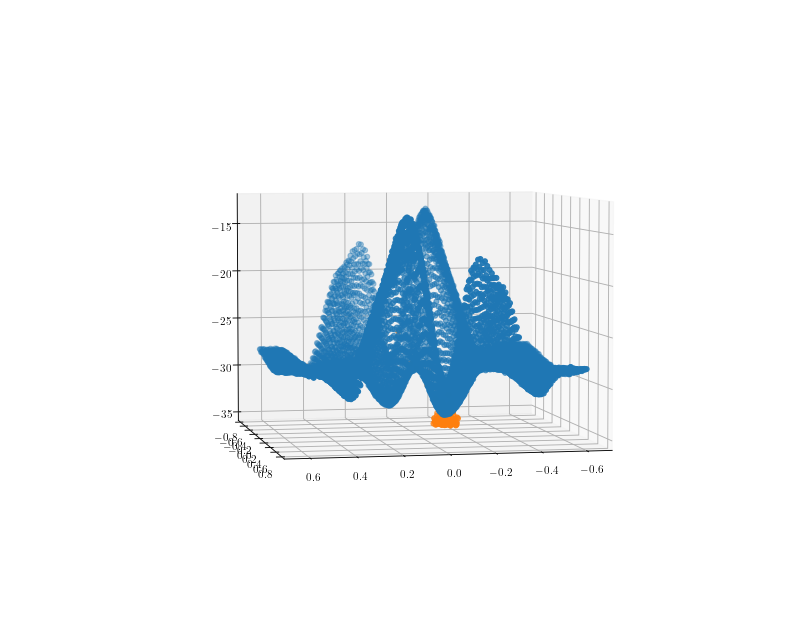

In [82]:
xs = X_coor

ys = Y_coor

zs = Z_coor

fig = plt.figure(figsize=(10, 8), dpi=80)

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs,ys,zs)
ax.scatter(X_pos, Y_pos,Z_pos)
plt.show()

In [111]:
np.savetxt('03QAOA_plain_x.txt', X_coor)
np.savetxt('03QAOA_plain_y.txt', Y_coor)
np.savetxt('03QAOA_plain_z.txt', Z_coor)

In [112]:
np.savetxt('03QAOA_pos_x.txt', X_pos)
np.savetxt('03QAOA_pos_y.txt', Y_pos)
np.savetxt('03QAOA_pos_z.txt', Z_pos)

In [49]:
X_coor_bak = X_coor
Y_coor_bak = Y_coor
Z_coor_bak = Z_coor
Counts_bak = Counts

### Simple gradient descent without scheduling

In [40]:
GRAD = get_gradient_qaoa(NUMBER, C, 10000)
result1, num_loops = gradient_descent(GRAD, [0.1,0.1], 0.035, 300, EPSILON=0.01)

In [41]:
print('Result parameters', result1)
print('Number of gradient calls', num_loops)

Result parameters [-1.0552285992368264, 0.9100598968880773]
Number of gradient calls 300


<IPython.core.display.Javascript object>


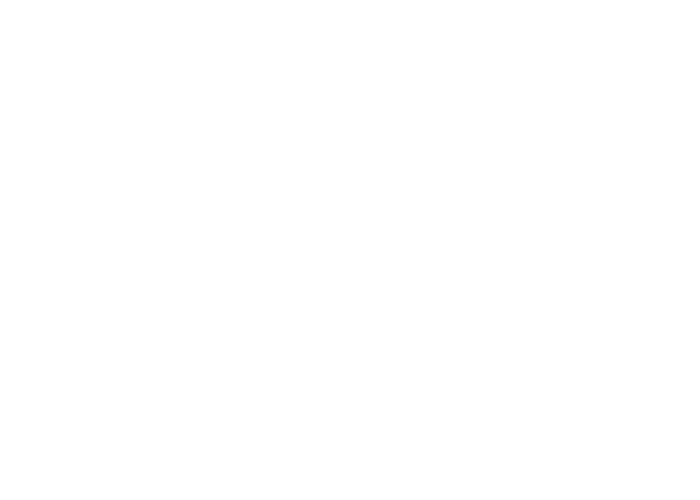

<IPython.core.display.Javascript object>


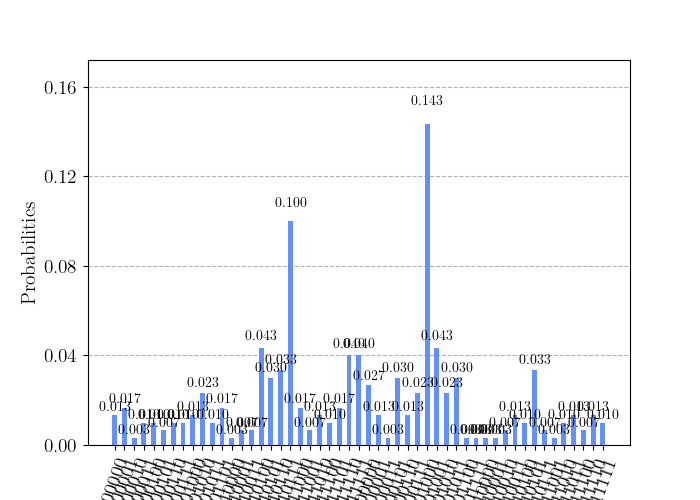

In [42]:
QC1 = construct_qaoa(6, result1)
counts1 = execute(QC1,Aer.get_backend('statevector_simulator'),shots=300).result().get_counts()
plot_histogram(counts1)

In [43]:
string, num = result_string(counts1)
print(string, cost_fun(string, C))

000101 -26.91


In [99]:
X_blue = []
Y_blue = []
X_orange = []
Y_orange = []
for it in range(len(string)):
    if (string[it] == '0'):
        X_blue.append(X[it])
        Y_blue.append(Y[it])
    else:
        X_orange.append(X[it])
        Y_orange.append(Y[it])

<IPython.core.display.Javascript object>


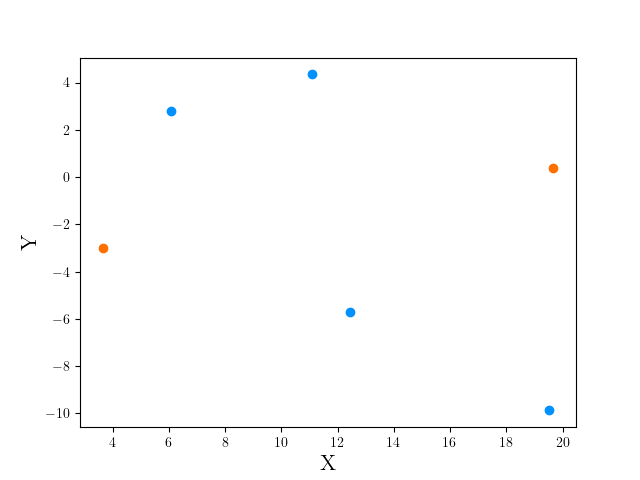

Text(0, 0.5, 'Y')

In [100]:
fig, ax = plt.subplots()
ax.scatter(x = X_blue, y = Y_blue,\
            color='#0091FF',\
            figure = fig)
ax.scatter(x = X_orange, y = Y_orange,\
            color='#FF6e00',\
            figure = fig)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
#plt.savefig('clustered_set.pdf')

### RMSProp optimization

In [81]:
GRAD = get_gradient_qaoa(NUMBER, C, 20000)
result3, num_loops, X_pos ,Y_pos = RMSProp(GRAD, [0.1,0.1], 0.035, 0.7, 300, EPSILON=0.001)

100%|██████████| 300/300 [00:17<00:00, 17.39it/s]


In [26]:
GRAD = get_gradient_qaoa(NUMBER, C, 20000)
result3, num_loops, X_pos ,Y_pos = RMSProp(GRAD, [0.1,0.1], 0.035, 0.7, 300, EPSILON=0.009)

 63%|██████▎   | 190/300 [00:10<00:06, 18.19it/s]


In [72]:
Z_pos = []
for i in range(len(X_pos)):
    qc_pok = construct_qaoa(NUMBER, [X_pos[i], Y_pos[i]])
    job_pok = execute(qc_pok,backend,shots=10000)
    e = expectation(job_pok.result().get_counts(),C)
    Z_pos.append(e)

In [27]:
print('Result parameters', result3)
print('Number of gradient calls', num_loops)

Result parameters [0.09995509129805337, -0.28776070989568947]
Number of gradient calls 190


<IPython.core.display.Javascript object>


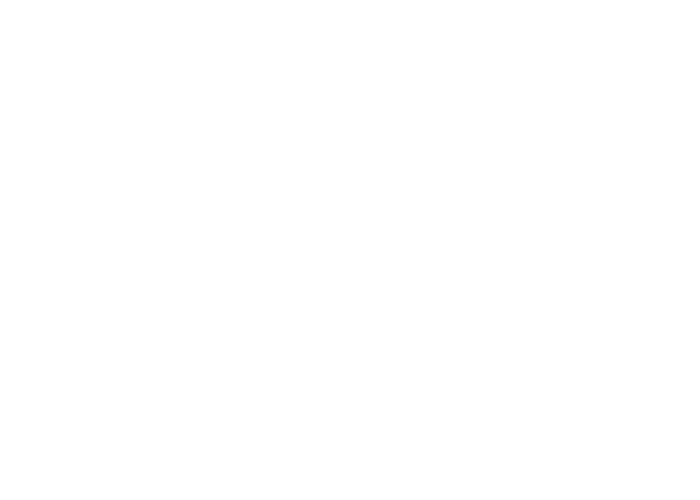

<IPython.core.display.Javascript object>


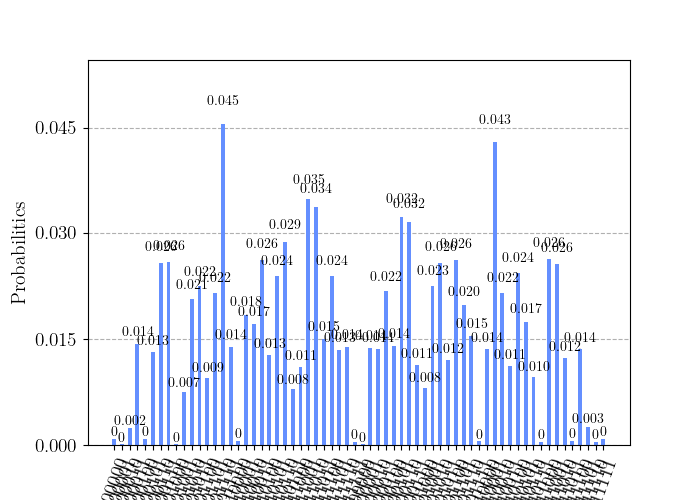

In [83]:
QC3 = construct_qaoa(NUMBER, result3)
counts3 = execute(QC3,Aer.get_backend('statevector_simulator'),shots=10000).result().get_counts()
#plot_histogram(counts3, filename='pok.pdf')
plot_histogram(counts3)

<IPython.core.display.Javascript object>


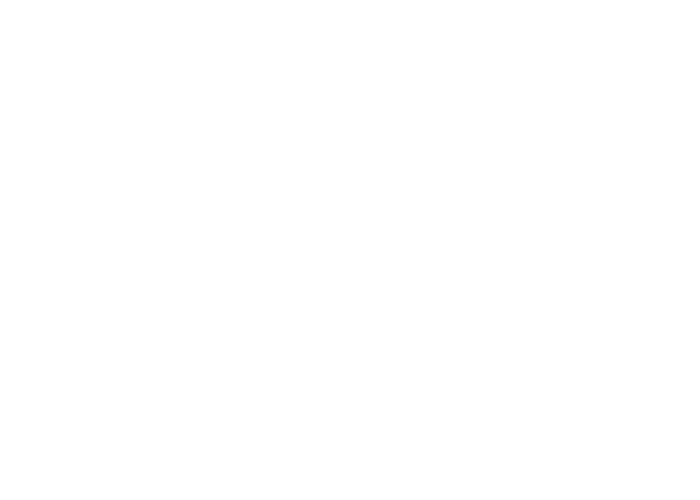

<IPython.core.display.Javascript object>


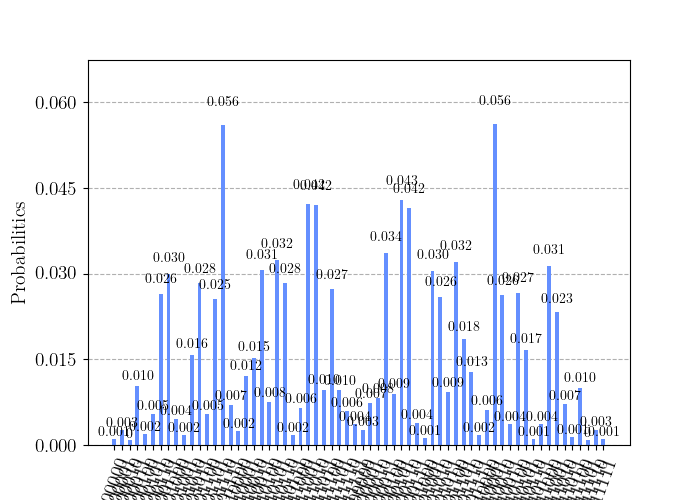

In [28]:
QC3 = construct_qaoa(NUMBER, result3)
counts3 = execute(QC3,Aer.get_backend('statevector_simulator'),shots=10000).result().get_counts()
#plot_histogram(counts3, filename='pok.pdf')
plot_histogram(counts3)

In [84]:
string, num = result_string(counts3)
print(string, cost_fun(string, C))

011100 -41.46000000000001


In [29]:
string, num = result_string(counts3)
print(string, cost_fun(string, C))

100011 -41.46000000000001


In [41]:
X_blue = []
Y_blue = []
X_orange = []
Y_orange = []
for it in range(len(string)):
    if (string[it] == '0'):
        X_blue.append(X[it])
        Y_blue.append(Y[it])
    else:
        X_orange.append(X[it])
        Y_orange.append(Y[it])

<IPython.core.display.Javascript object>


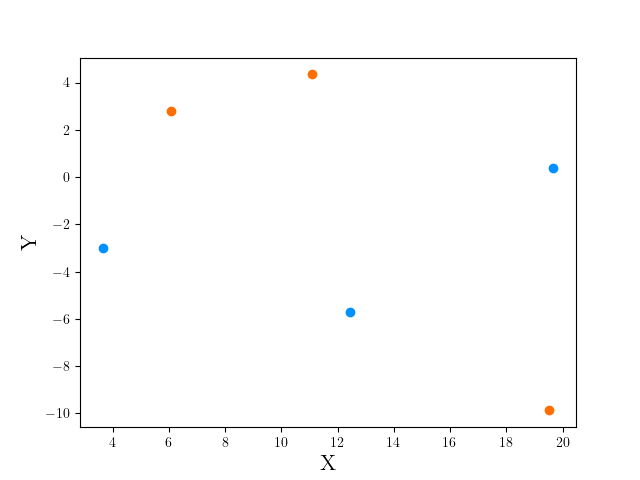

Text(0, 0.5, 'Y')

In [42]:
fig, ax = plt.subplots()
ax.scatter(x = X_blue, y = Y_blue,\
            color='#0091FF',\
            figure = fig)
ax.scatter(x = X_orange, y = Y_orange,\
            color='#FF6e00',\
            figure = fig)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
#plt.savefig('clustered_set.pdf')

### Gradient-free optimizer

In [105]:
CIRC = get_run_qaoa(NUMBER, C, 20000)
result4 = minimize(CIRC, [0.5,0.5], method='COBYLA', tol=1e-035, options={'maxiter':300,'disp':True})
# result4 is not an array!
result4

     fun: -31.311551500000007
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 189
  status: 1
 success: True
       x: array([2.07348202, 0.4721475 ])


   Normal return from subroutine COBYLA

   NFVALS =  189   F =-3.131155E+01    MAXCV = 0.000000E+00
   X = 2.073482E+00   4.721475E-01


<IPython.core.display.Javascript object>


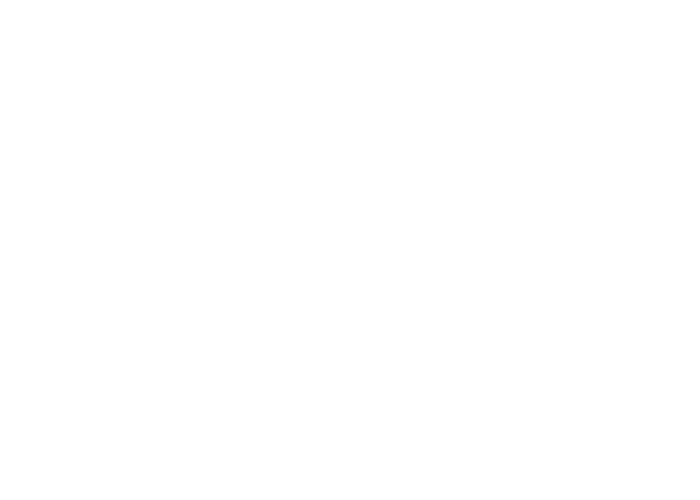

<IPython.core.display.Javascript object>


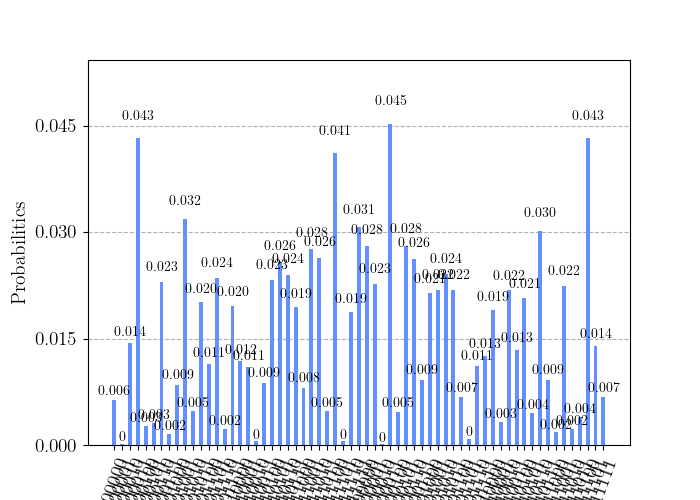

In [106]:
QC4 = construct_qaoa(NUMBER, result4.x)
counts4 = execute(QC4,Aer.get_backend('statevector_simulator'),shots=10000).result().get_counts()
plot_histogram(counts4)

In [107]:
string, num = result_string(counts4)
print(string, num)

110001 452


In [108]:
cost_fun(string,C)

-32.83

In [109]:
X_blue = []
Y_blue = []
X_orange = []
Y_orange = []
for it in range(len(string)):
    if (string[it] == '0'):
        X_blue.append(X[it])
        Y_blue.append(Y[it])
    else:
        X_orange.append(X[it])
        Y_orange.append(Y[it])

<IPython.core.display.Javascript object>


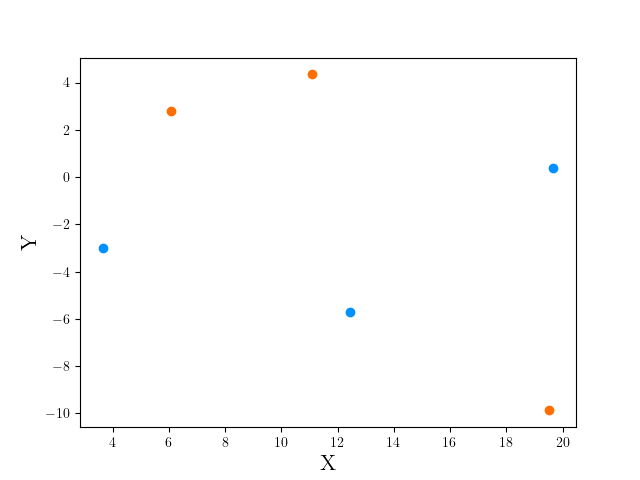

Text(0, 0.5, 'Y')

In [110]:
fig, ax = plt.subplots()
ax.scatter(x = X_blue, y = Y_blue,\
            color='#0091FF',\
            figure = fig)
ax.scatter(x = X_orange, y = Y_orange,\
            color='#FF6e00',\
            figure = fig)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
#plt.savefig('clustered_set.pdf')

## Measurements

In [117]:
COB_QAOA_results = []
COB_QAOA_val = []
COB_QAOA_nfev = []
shots = []
for SHOTS in trange(1000, 10000, 500):
    shots.append(SHOTS)
    res_tmp = []
    val_tmp = []
    nfev_tmp = []
    for it in range(10): 
        print('-------------- SHOTS =',SHOTS,' it=',it,'--------------')
        CIRC_tmp = get_run_qaoa(NUMBER, C, SHOTS)
        result_tmp = minimize(CIRC_tmp, [1.0,1.0], method='COBYLA',\
                              tol=1e-020, options={'maxiter':300,'disp':True})
        QC_tmp = construct_qaoa(NUMBER, result_tmp.x)
        counts_tmp = execute(QC_tmp,Aer.get_backend('statevector_simulator'),shots=1000).result().get_counts()
        val_tmp.append(result_tmp.fun)
        nfev_tmp.append(result_tmp.nfev)
        a = 0
        try:
            a += (counts_tmp['001110'])
        except KeyError as err:
            pass
        try:
            a += (counts_tmp['110001'])
        except KeyError as err:
            pass
        res_tmp.append(a)
    COB_QAOA_results.append(res_tmp)
    COB_QAOA_nfev.append(nfev_tmp)
    COB_QAOA_val.append(val_tmp)

  0%|          | 0/18 [00:00<?, ?it/s]

-------------- SHOTS = 1000  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  110   F =-3.053853E+01    MAXCV = 0.000000E+00
   X = 1.370431E+00   1.016777E+00
-------------- SHOTS = 1000  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.266713E+01    MAXCV = 0.000000E+00
   X = 1.819842E+00   2.132363E+00
-------------- SHOTS = 1000  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.240193E+01    MAXCV = 0.000000E+00
   X = 1.876245E+00   8.744018E-01
-------------- SHOTS = 1000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.048152E+01    MAXCV = 0.000000E+00
   X = 8.354598E-01   1.254491E+00
-------------- SHOTS = 1000  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.067338E+01    MAXCV = 0.000000E+00
   X = 8.444350E-01   1.083663E+00
-------------- SHOTS = 1000  it= 5 --------------

   Normal retu

  6%|▌         | 1/18 [00:18<05:12, 18.37s/it]


   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.357215E+01    MAXCV = 0.000000E+00
   X = 1.822947E+00   2.041944E+00
-------------- SHOTS = 1500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  114   F =-3.259563E+01    MAXCV = 0.000000E+00
   X = 1.832347E+00   2.015736E+00
-------------- SHOTS = 1500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.246325E+01    MAXCV = 0.000000E+00
   X = 1.805263E+00   1.919820E+00
-------------- SHOTS = 1500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.234569E+01    MAXCV = 0.000000E+00
   X = 1.807337E+00   1.907465E+00
-------------- SHOTS = 1500  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.271445E+01    MAXCV = 0.000000E+00
   X = 1.844231E+00   2.025845E+00
-------------- SHOTS = 1500  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  109   F =-

 11%|█         | 2/18 [00:39<05:20, 20.06s/it]


   Normal return from subroutine COBYLA

   NFVALS =  110   F =-3.094842E+01    MAXCV = 0.000000E+00
   X = 8.366914E-01   1.109916E+00
-------------- SHOTS = 2000  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.097105E+01    MAXCV = 0.000000E+00
   X = 8.090193E-01   1.110545E+00
-------------- SHOTS = 2000  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.284157E+01    MAXCV = 0.000000E+00
   X = 1.798692E+00   2.061925E+00
-------------- SHOTS = 2000  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.083756E+01    MAXCV = 0.000000E+00
   X = 8.219446E-01   9.517650E-01
-------------- SHOTS = 2000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.094874E+01    MAXCV = 0.000000E+00
   X = 8.216705E-01   1.196015E+00
-------------- SHOTS = 2000  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  111   F =-

 17%|█▋        | 3/18 [01:03<05:28, 21.90s/it]


   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.173735E+01    MAXCV = 0.000000E+00
   X = 1.273429E+00   8.180677E-01
-------------- SHOTS = 2500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  114   F =-3.291224E+01    MAXCV = 0.000000E+00
   X = 1.834976E+00   2.040151E+00
-------------- SHOTS = 2500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.065930E+01    MAXCV = 0.000000E+00
   X = 1.401113E+00   1.134819E+00
-------------- SHOTS = 2500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.085776E+01    MAXCV = 0.000000E+00
   X = 8.338985E-01   1.128102E+00
-------------- SHOTS = 2500  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.109061E+01    MAXCV = 0.000000E+00
   X = 2.095584E+00   2.178786E+00
-------------- SHOTS = 2500  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-

 22%|██▏       | 4/18 [01:29<05:30, 23.60s/it]


   Normal return from subroutine COBYLA

   NFVALS =  118   F =-3.109015E+01    MAXCV = 0.000000E+00
   X = 8.158535E-01   1.122266E+00
-------------- SHOTS = 3000  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.311200E+01    MAXCV = 0.000000E+00
   X = 1.820769E+00   2.165599E+00
-------------- SHOTS = 3000  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.316387E+01    MAXCV = 0.000000E+00
   X = 1.822298E+00   2.070123E+00
-------------- SHOTS = 3000  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.314892E+01    MAXCV = 0.000000E+00
   X = 1.826061E+00   2.173819E+00
-------------- SHOTS = 3000  it= 3 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS =   NFVALS =  114   F =-3.321789E+01    MAXCV = 0.000000E+00
   X = 1.822615E+00   2.199286E+00
 3000  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  113   F =-

 28%|██▊       | 5/18 [01:58<05:29, 25.37s/it]


   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.172806E+01    MAXCV = 0.000000E+00
   X = 1.241743E+00   7.993175E-01
-------------- SHOTS = 3500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.307669E+01    MAXCV = 0.000000E+00
   X = 1.850253E+00   2.262075E+00
-------------- SHOTS = 3500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.299659E+01    MAXCV = 0.000000E+00
   X = 1.851081E+00   2.306523E+00
-------------- SHOTS = 3500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.187605E+01    MAXCV = 0.000000E+00
   X = 1.258560E+00   7.240869E-01
-------------- SHOTS = 3500  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  120   F =-3.294084E+01    MAXCV = 0.000000E+00
   X = 1.814206E+00   2.036856E+00
-------------- SHOTS = 3500  it= 4 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

 

 33%|███▎      | 6/18 [02:30<05:29, 27.49s/it]


   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.276407E+01    MAXCV = 0.000000E+00
   X = 1.803163E+00   1.949700E+00
-------------- SHOTS = 4000  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.298109E+01    MAXCV = 0.000000E+00
   X = 1.811826E+00   2.017304E+00
-------------- SHOTS = 4000  it= 1 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS =   NFVALS =  109   F =-3.309861E+01    MAXCV = 0.000000E+00
   X = 1.816454E+00   2.166479E+00
 4000  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  125   F =-3.299960E+01    MAXCV = 0.000000E+00
   X = 1.802465E+00   2.011987E+00
-------------- SHOTS = 4000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  119   F =-3.216015E+01    MAXCV = 0.000000E+00
   X = 1.821840E+00   1.940029E+00
-------------- SHOTS = 4000  it= 4 --------------

   Normal return from subroutine COBYLA
-------------- SHOTS =
 

 39%|███▉      | 7/18 [03:05<05:30, 30.00s/it]


   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.253721E+01    MAXCV = 0.000000E+00
   X = 1.802301E+00   2.031328E+00
-------------- SHOTS = 4500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.256690E+01    MAXCV = 0.000000E+00
   X = 1.826642E+00   1.984858E+00
-------------- SHOTS = 4500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.070907E+01    MAXCV = 0.000000E+00
   X = 8.148336E-01   1.236290E+00
-------------- SHOTS = 4500  it= 2 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.297663E+01    MAXCV = 0.000000E+00
   X = 1.857111E+00   2.242457E+00
 4500  it= 3 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS =   NFVALS =  120   F =-3.312254E+01    MAXCV = 0.000000E+00
   X = 1.831570E+00   2.157218E+00
 4500  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  114   F =-

 44%|████▍     | 8/18 [03:40<05:17, 31.74s/it]


   Normal return from subroutine COBYLA

   NFVALS =  121   F =-3.272680E+01    MAXCV = 0.000000E+00
   X = 1.812981E+00   1.976096E+00
-------------- SHOTS = 5000  it= 0 --------------

   Normal return from subroutine COBYLA
-------------- SHOTS =
   NFVALS =  120   F =-3.302977E+01    MAXCV = 0.000000E+00
   X = 1.820673E+00   2.016692E+00
 5000  it= 1 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS =   NFVALS =  112   F =-3.084415E+01    MAXCV = 0.000000E+00
   X = 8.126223E-01   9.945810E-01
 5000  it= 2 --------------

   Normal return from subroutine COBYLA
-------------- SHOTS = 
   NFVALS =  115   F =-3.322079E+01    MAXCV = 0.000000E+00
   X = 1.822205E+00   2.144702E+00
5000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.302654E+01    MAXCV = 0.000000E+00
   X = 1.804639E+00   2.023397E+00
-------------- SHOTS = 5000  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-

 50%|█████     | 9/18 [04:18<05:03, 33.75s/it]


   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.094087E+01    MAXCV = 0.000000E+00
   X = 8.282041E-01   9.952215E-01
-------------- SHOTS = 5500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.318151E+01    MAXCV = 0.000000E+00
   X = 1.816129E+00   2.087536E+00
-------------- SHOTS = 5500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  114   F =-3.070593E+01    MAXCV = 0.000000E+00
   X = 8.093882E-01   1.255551E+00
-------------- SHOTS = 5500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.126053E+01    MAXCV = 0.000000E+00
   X = 2.084442E+00   2.099006E+00
-------------- SHOTS = 5500  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  108   F =-3.127945E+01    MAXCV = 0.000000E+00
   X = 2.083435E+00   2.152044E+00
-------------- SHOTS = 5500  it= 4 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS = 

 56%|█████▌    | 10/18 [04:57<04:42, 35.35s/it]


   Normal return from subroutine COBYLA

   NFVALS =  114   F =-3.285670E+01    MAXCV = 0.000000E+00
   X = 1.803476E+00   2.001276E+00
-------------- SHOTS = 6000  it= 0 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.233862E+01    MAXCV = 0.000000E+00
   X = 1.800503E+00   1.923021E+00
 6000  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  114   F =-3.313470E+01    MAXCV = 0.000000E+00
   X = 1.827378E+00   2.112414E+00
-------------- SHOTS = 6000  it= 2 --------------

   Normal return from subroutine COBYLA
-------------- SHOTS =
   NFVALS =  113   F =-3.314445E+01    MAXCV = 0.000000E+00
   X = 1.841699E+00   2.270438E+00
 6000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  108   F =-3.111959E+01    MAXCV = 0.000000E+00
   X = 2.057219E+00   2.178691E+00
-------------- SHOTS = 6000  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  113   F =-

 61%|██████    | 11/18 [05:40<04:22, 37.46s/it]


   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.310720E+01    MAXCV = 0.000000E+00
   X = 1.820564E+00   2.085917E+00
-------------- SHOTS = 6500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.294402E+01    MAXCV = 0.000000E+00
   X = 1.811763E+00   2.065369E+00
-------------- SHOTS = 6500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  110   F =-3.320941E+01    MAXCV = 0.000000E+00
   X = 1.820471E+00   2.167539E+00
-------------- SHOTS = 6500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.316016E+01    MAXCV = 0.000000E+00
   X = 1.836856E+00   2.098705E+00
-------------- SHOTS = 6500  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.289207E+01    MAXCV = 0.000000E+00
   X = 1.844681E+00   2.115986E+00
-------------- SHOTS = 6500  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  120   F =-

 67%|██████▋   | 12/18 [06:28<04:04, 40.75s/it]


   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.094280E+01    MAXCV = 0.000000E+00
   X = 1.408815E+00   1.024882E+00
-------------- SHOTS = 7000  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  110   F =-3.130087E+01    MAXCV = 0.000000E+00
   X = 2.079134E+00   2.114084E+00
-------------- SHOTS = 7000  it= 1 --------------

-------------- SHOTS = 7000  it=    Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.268676E+01    MAXCV = 0.000000E+00
   X = 1.805113E+00   2.008358E+00
2 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  114   F =-3.296294E+01    MAXCV = 0.000000E+00
   X = 1.815683E+00   2.008802E+00
 7000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  122   F =-3.272777E+01    MAXCV = 0.000000E+00
   X = 1.783074E+00   1.951442E+00
-------------- SHOTS = 7000  it= 4 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

 

 72%|███████▏  | 13/18 [07:15<03:33, 42.65s/it]


   Normal return from subroutine COBYLA

   NFVALS =  123   F =-3.268841E+01    MAXCV = 0.000000E+00
   X = 1.871080E+00   2.362792E+00
-------------- SHOTS = 7500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  118   F =-3.272193E+01    MAXCV = 0.000000E+00
   X = 1.795353E+00   2.001296E+00
-------------- SHOTS = 7500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.084036E+01    MAXCV = 0.000000E+00
   X = 8.166873E-01   9.946548E-01
-------------- SHOTS = 7500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  111   F =-3.083460E+01    MAXCV = 0.000000E+00
   X = 8.077421E-01   1.173550E+00
-------------- SHOTS = 7500  it= 3 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.135153E+01    MAXCV = 0.000000E+00
   X = 2.071285E+00   2.026649E+00
 7500  it= 4 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS = 

 78%|███████▊  | 14/18 [08:04<02:58, 44.53s/it]


   Normal return from subroutine COBYLA

   NFVALS =  113   F =-3.086709E+01    MAXCV = 0.000000E+00
   X = 7.996425E-01   1.051171E+00
-------------- SHOTS = 8000  it= 0 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  118   F =-3.117464E+01    MAXCV = 0.000000E+00
   X = 2.087315E+00   2.114134E+00
 8000  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.276522E+01    MAXCV = 0.000000E+00
   X = 1.793311E+00   2.053454E+00
-------------- SHOTS = 8000  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.311759E+01    MAXCV = 0.000000E+00
   X = 1.838345E+00   2.237849E+00
-------------- SHOTS = 8000  it= 3 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  118   F =-3.330982E+01    MAXCV = 0.000000E+00
   X = 1.839295E+00   2.233939E+00
 8000  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  119   F =-

 83%|████████▎ | 15/18 [08:57<02:21, 47.12s/it]


   Normal return from subroutine COBYLA

   NFVALS =  120   F =-3.099240E+01    MAXCV = 0.000000E+00
   X = 8.164188E-01   9.959608E-01
-------------- SHOTS = 8500  it= 0 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.244552E+01    MAXCV = 0.000000E+00
   X = 1.781983E+00   1.938434E+00
 8500  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  123   F =-3.326285E+01    MAXCV = 0.000000E+00
   X = 1.845489E+00   2.172616E+00
-------------- SHOTS = 8500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  110   F =-3.316222E+01    MAXCV = 0.000000E+00
   X = 1.835843E+00   2.184076E+00
-------------- SHOTS = 8500  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  118   F =-3.289234E+01    MAXCV = 0.000000E+00
   X = 1.857654E+00   2.307631E+00
-------------- SHOTS = 8500  it= 4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  120   F =-

 89%|████████▉ | 16/18 [09:49<01:37, 48.63s/it]


   Normal return from subroutine COBYLA

   NFVALS =  127   F =-3.285182E+01    MAXCV = 0.000000E+00
   X = 1.817473E+00   2.044017E+00
-------------- SHOTS = 9000  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  108   F =-3.081468E+01    MAXCV = 0.000000E+00
   X = 7.913381E-01   1.126735E+00
-------------- SHOTS = 9000  it= 1 --------------

   Normal return from subroutine COBYLA

   NFVALS =  121   F =-3.294215E+01    MAXCV = 0.000000E+00
   X = 1.823667E+00   2.034207E+00
-------------- SHOTS = 9000  it= 2 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  115   F =-3.137549E+01    MAXCV = 0.000000E+00
   X = 2.063821E+00   2.059881E+00
 9000  it= 3 --------------

   Normal return from subroutine COBYLA

   NFVALS =  116   F =-3.083543E+01    MAXCV = 0.000000E+00
   X = 7.943782E-01   1.141869E+00
-------------- SHOTS = 9000  it= 4 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS = 

 94%|█████████▍| 17/18 [10:44<00:50, 50.45s/it]


   Normal return from subroutine COBYLA

   NFVALS =  122   F =-3.316252E+01    MAXCV = 0.000000E+00
   X = 1.825160E+00   2.154347E+00
-------------- SHOTS = 9500  it= 0 --------------

   Normal return from subroutine COBYLA

   NFVALS =  124   F =-3.293267E+01    MAXCV = 0.000000E+00
   X = 1.815544E+00   2.023142E+00
-------------- SHOTS = 9500  it= 1 --------------

-------------- SHOTS =   Normal return from subroutine COBYLA

   NFVALS =  120   F =-3.308235E+01    MAXCV = 0.000000E+00
   X = 1.817155E+00   2.097408E+00
 9500  it= 2 --------------

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-3.121965E+01    MAXCV = 0.000000E+00
   X = 2.043889E+00   2.130934E+00
-------------- SHOTS = 9500  it= 3 --------------

   Normal return from subroutine COBYLA

-------------- SHOTS = 9500  it=    NFVALS =  110   F =-3.128078E+01    MAXCV = 0.000000E+00
   X = 2.081439E+00   2.155540E+00
4 --------------

   Normal return from subroutine COBYLA

   NFVALS =  117   F =-

100%|██████████| 18/18 [11:41<00:00, 38.96s/it]


   Normal return from subroutine COBYLA

   NFVALS =  117   F =-3.278161E+01    MAXCV = 0.000000E+00
   X = 1.864682E+00   2.363849E+00


In [118]:
for i in range(len(COB_QAOA_results)):
    for j in range(len(COB_QAOA_results[i])):
        COB_QAOA_results[i][j] = COB_QAOA_results[i][j]/1000
COB_QAOA_results_df = pd.DataFrame(COB_QAOA_results)
COB_QAOA_nfev_df = pd.DataFrame(COB_QAOA_nfev)
COB_QAOA_val_df = pd.DataFrame(COB_QAOA_val)
COB_QAOA_results_df.to_csv("COB_QAOA_results_df.csv", index=False)
COB_QAOA_nfev_df.to_csv("COB_QAOA_nfev_df.csv", index=False)
COB_QAOA_val_df.to_csv("COB_QAOA_val_df.csv", index=False)
COB_QAOA_res_proc = pd_process(COB_QAOA_results_df)
COB_QAOA_nfev_proc = pd_process(COB_QAOA_nfev_df)
COB_QAOA_val_proc = pd_process(COB_QAOA_val_df)

In [119]:
x_coor = pd.Series(shots)

<IPython.core.display.Javascript object>


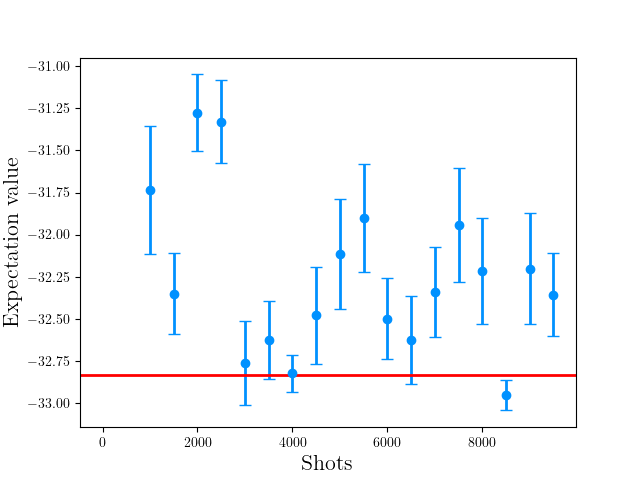

In [125]:
data = COB_QAOA_val_proc
fig, ax = plt.subplots()
#ax.set_ylim([-0.76, -0.42])
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.axline(xy1= [0.0,-32.83], slope = 0, color = 'red', linewidth = 2)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Expectation value', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('COB_QAOA_results.pdf')

<IPython.core.display.Javascript object>


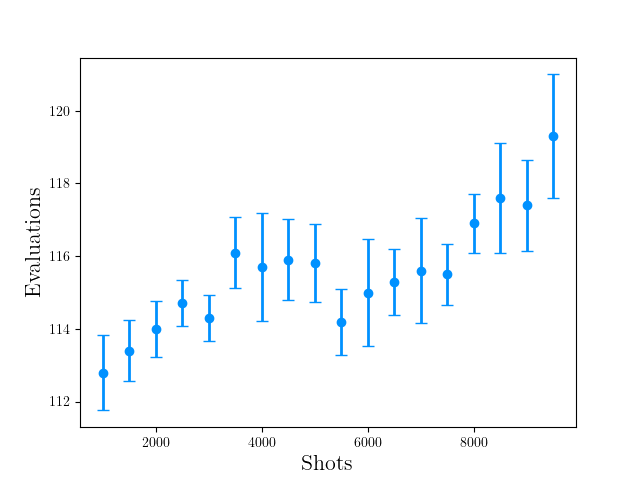

In [121]:
data = COB_QAOA_nfev_proc
fig, ax = plt.subplots()
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Evaluations', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('COB_QAOA_nfev.pdf')

## Measurements

In [30]:
RMSProp_QAOA_results = []
RMSProp_QAOA_val = []
RMSProp_QAOA_nfev = []
shots = []
for SHOTS in range(1000, 10000, 500):
    shots.append(SHOTS)
    res_tmp = []
    val_tmp = []
    nfev_tmp = []
    for it in range(10): 
        print('-------------- SHOTS =',SHOTS,' it=',it,'--------------')
        GRAD_tmp = get_gradient_qaoa(NUMBER, C, SHOTS)
        result_tmp, num_loops_tmp, X_pos_tmp ,Y_pos_tmp = RMSProp(GRAD_tmp, [0.1,0.1], 0.035, 0.7, 300, EPSILON=0.009)
        QC_tmp = construct_qaoa(NUMBER, result_tmp)
        counts_tmp = execute(QC_tmp,Aer.get_backend('statevector_simulator'),shots=1000).result().get_counts()
        val_tmp.append(expectation(counts_tmp, C))
        nfev_tmp.append(num_loops_tmp)
        a = 0
        try:
            a += (counts_tmp['001110'])
        except KeyError as err:
            pass
        try:
            a += (counts_tmp['110001'])
        except KeyError as err:
            pass
        res_tmp.append(a)
    RMSProp_QAOA_results.append(res_tmp)
    RMSProp_QAOA_nfev.append(nfev_tmp)
    RMSProp_QAOA_val.append(val_tmp)

-------------- SHOTS = 1000  it= 0 --------------


 90%|█████████ | 270/300 [00:15<00:01, 17.97it/s]


-------------- SHOTS = 1000  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.41it/s]


-------------- SHOTS = 1000  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.32it/s]


-------------- SHOTS = 1000  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 17.66it/s]


-------------- SHOTS = 1000  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.07it/s]


-------------- SHOTS = 1000  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.20it/s]


-------------- SHOTS = 1000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.16it/s]


-------------- SHOTS = 1000  it= 7 --------------


 53%|█████▎    | 159/300 [00:08<00:07, 17.87it/s]


-------------- SHOTS = 1000  it= 8 --------------


 17%|█▋        | 50/300 [00:02<00:14, 17.61it/s]


-------------- SHOTS = 1000  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 18.11it/s]


-------------- SHOTS = 1500  it= 0 --------------


 56%|█████▌    | 168/300 [00:09<00:07, 18.11it/s]


-------------- SHOTS = 1500  it= 1 --------------


100%|██████████| 300/300 [00:17<00:00, 16.67it/s]


-------------- SHOTS = 1500  it= 2 --------------


100%|██████████| 300/300 [00:17<00:00, 17.04it/s]


-------------- SHOTS = 1500  it= 3 --------------


 48%|████▊     | 145/300 [00:08<00:08, 17.65it/s]


-------------- SHOTS = 1500  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 17.76it/s]


-------------- SHOTS = 1500  it= 5 --------------


100%|██████████| 300/300 [00:17<00:00, 17.12it/s]


-------------- SHOTS = 1500  it= 6 --------------


100%|██████████| 300/300 [00:17<00:00, 17.45it/s]


-------------- SHOTS = 1500  it= 7 --------------


100%|██████████| 300/300 [00:18<00:00, 16.52it/s]


-------------- SHOTS = 1500  it= 8 --------------


100%|██████████| 300/300 [00:17<00:00, 17.52it/s]


-------------- SHOTS = 1500  it= 9 --------------


100%|██████████| 300/300 [00:17<00:00, 17.62it/s]


-------------- SHOTS = 2000  it= 0 --------------


100%|██████████| 300/300 [00:18<00:00, 16.06it/s]


-------------- SHOTS = 2000  it= 1 --------------


100%|██████████| 300/300 [00:17<00:00, 16.75it/s]


-------------- SHOTS = 2000  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 17.71it/s]


-------------- SHOTS = 2000  it= 3 --------------


100%|██████████| 300/300 [00:18<00:00, 16.61it/s]


-------------- SHOTS = 2000  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 17.79it/s]


-------------- SHOTS = 2000  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.02it/s]


-------------- SHOTS = 2000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.25it/s]


-------------- SHOTS = 2000  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 18.14it/s]


-------------- SHOTS = 2000  it= 8 --------------


 10%|█         | 30/300 [00:01<00:16, 16.28it/s]


-------------- SHOTS = 2000  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 17.87it/s]


-------------- SHOTS = 2500  it= 0 --------------


 22%|██▏       | 67/300 [00:03<00:13, 17.79it/s]


-------------- SHOTS = 2500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.18it/s]


-------------- SHOTS = 2500  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.15it/s]


-------------- SHOTS = 2500  it= 3 --------------


100%|██████████| 300/300 [00:17<00:00, 16.94it/s]


-------------- SHOTS = 2500  it= 4 --------------


100%|██████████| 300/300 [00:18<00:00, 16.10it/s]


-------------- SHOTS = 2500  it= 5 --------------


 40%|████      | 121/300 [00:06<00:10, 17.35it/s]


-------------- SHOTS = 2500  it= 6 --------------


 22%|██▏       | 67/300 [00:03<00:13, 16.97it/s]


-------------- SHOTS = 2500  it= 7 --------------


 47%|████▋     | 140/300 [00:07<00:09, 17.62it/s]


-------------- SHOTS = 2500  it= 8 --------------


100%|██████████| 300/300 [00:16<00:00, 17.67it/s]


-------------- SHOTS = 2500  it= 9 --------------


100%|██████████| 300/300 [00:17<00:00, 17.29it/s]


-------------- SHOTS = 3000  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 17.69it/s]


-------------- SHOTS = 3000  it= 1 --------------


 21%|██        | 63/300 [00:03<00:14, 16.84it/s]


-------------- SHOTS = 3000  it= 2 --------------


100%|██████████| 300/300 [00:17<00:00, 17.63it/s]


-------------- SHOTS = 3000  it= 3 --------------


100%|██████████| 300/300 [00:17<00:00, 17.60it/s]


-------------- SHOTS = 3000  it= 4 --------------


100%|██████████| 300/300 [00:17<00:00, 17.64it/s]


-------------- SHOTS = 3000  it= 5 --------------


 23%|██▎       | 68/300 [00:03<00:13, 17.29it/s]


-------------- SHOTS = 3000  it= 6 --------------


100%|██████████| 300/300 [00:17<00:00, 17.58it/s]


-------------- SHOTS = 3000  it= 7 --------------


100%|██████████| 300/300 [00:17<00:00, 17.62it/s]


-------------- SHOTS = 3000  it= 8 --------------


 63%|██████▎   | 190/300 [00:10<00:06, 17.55it/s]


-------------- SHOTS = 3000  it= 9 --------------


100%|██████████| 300/300 [00:17<00:00, 17.61it/s]


-------------- SHOTS = 3500  it= 0 --------------


 22%|██▏       | 67/300 [00:03<00:13, 17.22it/s]


-------------- SHOTS = 3500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 17.66it/s]


-------------- SHOTS = 3500  it= 2 --------------


100%|██████████| 300/300 [00:17<00:00, 17.43it/s]


-------------- SHOTS = 3500  it= 3 --------------


 42%|████▏     | 126/300 [00:07<00:09, 17.50it/s]


-------------- SHOTS = 3500  it= 4 --------------


100%|██████████| 300/300 [00:17<00:00, 17.59it/s]


-------------- SHOTS = 3500  it= 5 --------------


100%|██████████| 300/300 [00:17<00:00, 17.64it/s]


-------------- SHOTS = 3500  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 17.65it/s]


-------------- SHOTS = 3500  it= 7 --------------


 28%|██▊       | 84/300 [00:04<00:12, 16.96it/s]


-------------- SHOTS = 3500  it= 8 --------------


100%|██████████| 300/300 [00:17<00:00, 17.57it/s]


-------------- SHOTS = 3500  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 4000  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.12it/s]


-------------- SHOTS = 4000  it= 1 --------------


  9%|▉         | 28/300 [00:01<00:17, 15.97it/s]


-------------- SHOTS = 4000  it= 2 --------------


 67%|██████▋   | 200/300 [00:10<00:05, 18.22it/s]


-------------- SHOTS = 4000  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 17.91it/s]


-------------- SHOTS = 4000  it= 4 --------------


  5%|▌         | 16/300 [00:00<00:16, 16.74it/s]


-------------- SHOTS = 4000  it= 5 --------------


 94%|█████████▍| 283/300 [00:15<00:00, 17.86it/s]


-------------- SHOTS = 4000  it= 6 --------------


 15%|█▍        | 44/300 [00:02<00:14, 17.58it/s]


-------------- SHOTS = 4000  it= 7 --------------


 52%|█████▏    | 157/300 [00:08<00:07, 18.13it/s]


-------------- SHOTS = 4000  it= 8 --------------


 87%|████████▋ | 261/300 [00:14<00:02, 17.95it/s]


-------------- SHOTS = 4000  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 18.10it/s]


-------------- SHOTS = 4500  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 17.98it/s]


-------------- SHOTS = 4500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.10it/s]


-------------- SHOTS = 4500  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.06it/s]


-------------- SHOTS = 4500  it= 3 --------------


 58%|█████▊    | 173/300 [00:09<00:07, 17.68it/s]


-------------- SHOTS = 4500  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.12it/s]


-------------- SHOTS = 4500  it= 5 --------------


 51%|█████     | 152/300 [00:08<00:08, 17.52it/s]


-------------- SHOTS = 4500  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.13it/s]


-------------- SHOTS = 4500  it= 7 --------------


 86%|████████▋ | 259/300 [00:14<00:02, 18.18it/s]


-------------- SHOTS = 4500  it= 8 --------------


100%|██████████| 300/300 [00:16<00:00, 17.89it/s]


-------------- SHOTS = 4500  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 17.90it/s]


-------------- SHOTS = 5000  it= 0 --------------


 70%|██████▉   | 209/300 [00:11<00:05, 18.05it/s]


-------------- SHOTS = 5000  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.19it/s]


-------------- SHOTS = 5000  it= 2 --------------


 22%|██▏       | 65/300 [00:03<00:14, 16.50it/s]


-------------- SHOTS = 5000  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 18.10it/s]


-------------- SHOTS = 5000  it= 4 --------------


 28%|██▊       | 84/300 [00:04<00:12, 17.49it/s]


-------------- SHOTS = 5000  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.15it/s]


-------------- SHOTS = 5000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.11it/s]


-------------- SHOTS = 5000  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


-------------- SHOTS = 5000  it= 8 --------------


100%|██████████| 300/300 [00:16<00:00, 17.97it/s]


-------------- SHOTS = 5000  it= 9 --------------


  5%|▍         | 14/300 [00:00<00:17, 16.32it/s]


-------------- SHOTS = 5500  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.11it/s]


-------------- SHOTS = 5500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.03it/s]


-------------- SHOTS = 5500  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.13it/s]


-------------- SHOTS = 5500  it= 3 --------------


 25%|██▌       | 76/300 [00:04<00:13, 17.10it/s]


-------------- SHOTS = 5500  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.13it/s]


-------------- SHOTS = 5500  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.01it/s]


-------------- SHOTS = 5500  it= 6 --------------


 83%|████████▎ | 248/300 [00:13<00:02, 18.06it/s]


-------------- SHOTS = 5500  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 17.95it/s]


-------------- SHOTS = 5500  it= 8 --------------


 31%|███       | 92/300 [00:05<00:11, 17.54it/s]


-------------- SHOTS = 5500  it= 9 --------------


 25%|██▍       | 74/300 [00:04<00:12, 17.75it/s]


-------------- SHOTS = 6000  it= 0 --------------


 81%|████████▏ | 244/300 [00:13<00:03, 17.93it/s]


-------------- SHOTS = 6000  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 6000  it= 2 --------------


 29%|██▊       | 86/300 [00:04<00:12, 17.80it/s]


-------------- SHOTS = 6000  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 18.02it/s]


-------------- SHOTS = 6000  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.18it/s]


-------------- SHOTS = 6000  it= 5 --------------


 53%|█████▎    | 160/300 [00:09<00:07, 17.68it/s]


-------------- SHOTS = 6000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 6000  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 17.96it/s]


-------------- SHOTS = 6000  it= 8 --------------


100%|██████████| 300/300 [00:16<00:00, 18.23it/s]


-------------- SHOTS = 6000  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 18.13it/s]


-------------- SHOTS = 6500  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


-------------- SHOTS = 6500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.02it/s]


-------------- SHOTS = 6500  it= 2 --------------


 46%|████▋     | 139/300 [00:07<00:09, 17.74it/s]


-------------- SHOTS = 6500  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


-------------- SHOTS = 6500  it= 4 --------------


 95%|█████████▌| 286/300 [00:15<00:00, 18.03it/s]


-------------- SHOTS = 6500  it= 5 --------------


 58%|█████▊    | 174/300 [00:09<00:06, 18.02it/s]


-------------- SHOTS = 6500  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 6500  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 18.18it/s]


-------------- SHOTS = 6500  it= 8 --------------


100%|██████████| 300/300 [00:16<00:00, 18.19it/s]


-------------- SHOTS = 6500  it= 9 --------------


 91%|█████████▏| 274/300 [00:15<00:01, 18.22it/s]


-------------- SHOTS = 7000  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.25it/s]


-------------- SHOTS = 7000  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.21it/s]


-------------- SHOTS = 7000  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 17.81it/s]


-------------- SHOTS = 7000  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 17.92it/s]


-------------- SHOTS = 7000  it= 4 --------------


 86%|████████▋ | 259/300 [00:14<00:02, 18.02it/s]


-------------- SHOTS = 7000  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


-------------- SHOTS = 7000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 17.96it/s]


-------------- SHOTS = 7000  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 17.83it/s]


-------------- SHOTS = 7000  it= 8 --------------


 81%|████████  | 243/300 [00:13<00:03, 17.93it/s]


-------------- SHOTS = 7000  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 17.97it/s]


-------------- SHOTS = 7500  it= 0 --------------


 14%|█▍        | 43/300 [00:02<00:15, 16.68it/s]


-------------- SHOTS = 7500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 17.93it/s]


-------------- SHOTS = 7500  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.06it/s]


-------------- SHOTS = 7500  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 7500  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.03it/s]


-------------- SHOTS = 7500  it= 5 --------------


 23%|██▎       | 68/300 [00:03<00:13, 17.63it/s]


-------------- SHOTS = 7500  it= 6 --------------


 13%|█▎        | 39/300 [00:02<00:15, 17.10it/s]


-------------- SHOTS = 7500  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 7500  it= 8 --------------


 20%|█▉        | 59/300 [00:03<00:13, 17.55it/s]


-------------- SHOTS = 7500  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 18.03it/s]


-------------- SHOTS = 8000  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.08it/s]


-------------- SHOTS = 8000  it= 1 --------------


 24%|██▎       | 71/300 [00:04<00:13, 17.14it/s]


-------------- SHOTS = 8000  it= 2 --------------


 69%|██████▉   | 208/300 [00:11<00:05, 18.14it/s]


-------------- SHOTS = 8000  it= 3 --------------


 54%|█████▎    | 161/300 [00:09<00:07, 17.67it/s]


-------------- SHOTS = 8000  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


-------------- SHOTS = 8000  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.11it/s]


-------------- SHOTS = 8000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 17.98it/s]


-------------- SHOTS = 8000  it= 7 --------------


 47%|████▋     | 140/300 [00:07<00:09, 17.54it/s]


-------------- SHOTS = 8000  it= 8 --------------


100%|██████████| 300/300 [00:16<00:00, 18.13it/s]


-------------- SHOTS = 8000  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 8500  it= 0 --------------


100%|██████████| 300/300 [00:17<00:00, 17.07it/s]


-------------- SHOTS = 8500  it= 1 --------------


 58%|█████▊    | 175/300 [00:09<00:06, 18.20it/s]


-------------- SHOTS = 8500  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.14it/s]


-------------- SHOTS = 8500  it= 3 --------------


 71%|███████   | 213/300 [00:11<00:04, 17.86it/s]


-------------- SHOTS = 8500  it= 4 --------------


 71%|███████▏  | 214/300 [00:11<00:04, 18.01it/s]


-------------- SHOTS = 8500  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.08it/s]


-------------- SHOTS = 8500  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.05it/s]


-------------- SHOTS = 8500  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 18.10it/s]


-------------- SHOTS = 8500  it= 8 --------------


 50%|█████     | 150/300 [00:08<00:08, 17.67it/s]


-------------- SHOTS = 8500  it= 9 --------------


100%|██████████| 300/300 [00:16<00:00, 17.98it/s]


-------------- SHOTS = 9000  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.10it/s]


-------------- SHOTS = 9000  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.08it/s]


-------------- SHOTS = 9000  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.21it/s]


-------------- SHOTS = 9000  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


-------------- SHOTS = 9000  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


-------------- SHOTS = 9000  it= 5 --------------


100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


-------------- SHOTS = 9000  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.06it/s]


-------------- SHOTS = 9000  it= 7 --------------


 42%|████▏     | 126/300 [00:06<00:09, 18.16it/s]


-------------- SHOTS = 9000  it= 8 --------------


 21%|██        | 63/300 [00:03<00:14, 16.80it/s]


-------------- SHOTS = 9000  it= 9 --------------


  8%|▊         | 24/300 [00:01<00:16, 16.61it/s]


-------------- SHOTS = 9500  it= 0 --------------


100%|██████████| 300/300 [00:16<00:00, 18.09it/s]


-------------- SHOTS = 9500  it= 1 --------------


100%|██████████| 300/300 [00:16<00:00, 18.09it/s]


-------------- SHOTS = 9500  it= 2 --------------


100%|██████████| 300/300 [00:16<00:00, 18.02it/s]


-------------- SHOTS = 9500  it= 3 --------------


100%|██████████| 300/300 [00:16<00:00, 18.09it/s]


-------------- SHOTS = 9500  it= 4 --------------


100%|██████████| 300/300 [00:16<00:00, 18.23it/s]


-------------- SHOTS = 9500  it= 5 --------------


 90%|████████▉ | 269/300 [00:15<00:01, 17.90it/s]


-------------- SHOTS = 9500  it= 6 --------------


100%|██████████| 300/300 [00:16<00:00, 18.03it/s]


-------------- SHOTS = 9500  it= 7 --------------


100%|██████████| 300/300 [00:16<00:00, 18.04it/s]


-------------- SHOTS = 9500  it= 8 --------------


 18%|█▊        | 55/300 [00:03<00:13, 17.72it/s]


-------------- SHOTS = 9500  it= 9 --------------


 21%|██        | 62/300 [00:03<00:13, 17.60it/s]


In [31]:
for i in range(len(RMSProp_QAOA_results)):
    for j in range(len(RMSProp_QAOA_results[i])):
        RMSProp_QAOA_results[i][j] = RMSProp_QAOA_results[i][j]/1000
RMSProp_QAOA_results_df = pd.DataFrame(RMSProp_QAOA_results)
RMSProp_QAOA_nfev_df = pd.DataFrame(RMSProp_QAOA_nfev)
RMSProp_QAOA_val_df = pd.DataFrame(RMSProp_QAOA_val)
RMSProp_QAOA_results_df.to_csv("RMSProp_QAOA_results_df.csv", index=False)
RMSProp_QAOA_nfev_df.to_csv("RMSProp_QAOA_nfev_df.csv", index=False)
RMSProp_QAOA_val_df.to_csv("RMSProp_QAOA_val_df.csv", index=False)
RMSProp_QAOA_res_proc = pd_process(RMSProp_QAOA_results_df)
RMSProp_QAOA_nfev_proc = pd_process(RMSProp_QAOA_nfev_df)
RMSProp_QAOA_val_proc = pd_process(RMSProp_QAOA_val_df)

In [32]:
x_coor = pd.Series(shots)
np.savetxt('03QAOA_shots_x.txt', x_coor)

<IPython.core.display.Javascript object>


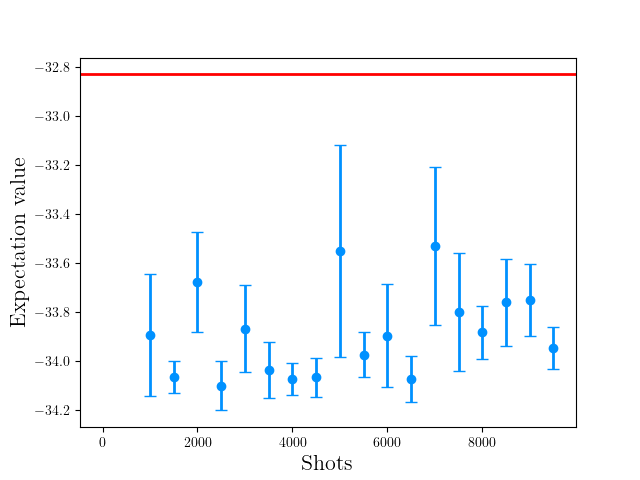

In [34]:
data = RMSProp_QAOA_val_proc
fig, ax = plt.subplots()
#ax.set_ylim([-0.76, -0.42])
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.axline(xy1= [0.0,-32.83], slope = 0, color = 'red', linewidth = 2)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Expectation value', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('RMSProp_QAOA_results.pdf')

<IPython.core.display.Javascript object>


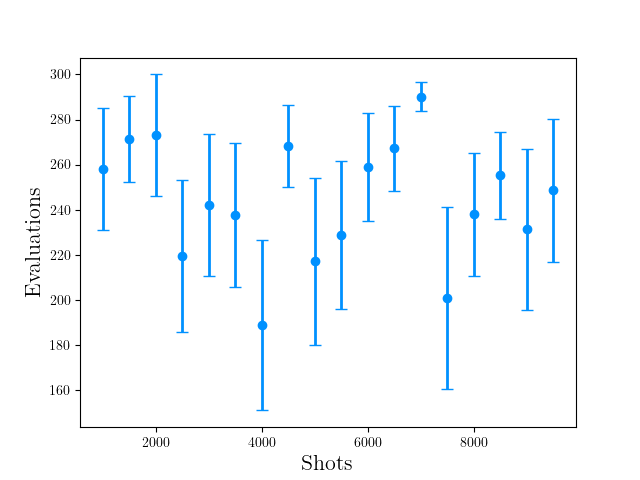

In [35]:
data = RMSProp_QAOA_nfev_proc
fig, ax = plt.subplots()
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Evaluations', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('RMSProp_QAOA_nfev.pdf')

In [31]:
import qiskit.tools.jupyter
%qiskit_version_table

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

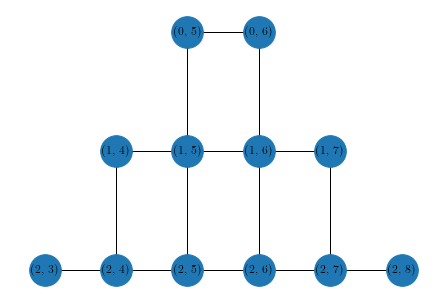

In [19]:
import cirq
from typing import List
import sympy
import numpy as np
import matplotlib.pyplot as plt

import cirq_google

working_device = cirq_google.Sycamore
print(working_device)

import networkx as nx

# Set the seed to determine the problem instance.
np.random.seed(seed=11)

# Identify working qubits from the device.
device_qubits = working_device.qubits
working_qubits = sorted(device_qubits)[:12]

# Populate a networkx graph with working_qubits as nodes.
working_graph = working_device.metadata.nx_graph.subgraph(working_qubits)

# Add random weights to edges of the graph. Each weight is a 2 decimal floating point between 0 and 5.
nx.set_edge_attributes(
    working_graph,
    {e: {"weight": np.random.randint(0, 500) / 100} for e in working_graph.edges},
)

# Draw the working_graph on a 2d grid
pos = {q: (q.col, -q.row) for q in working_graph.nodes()}
nx.draw(working_graph, pos=pos, with_labels=True, node_size=1000)
plt.show()


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


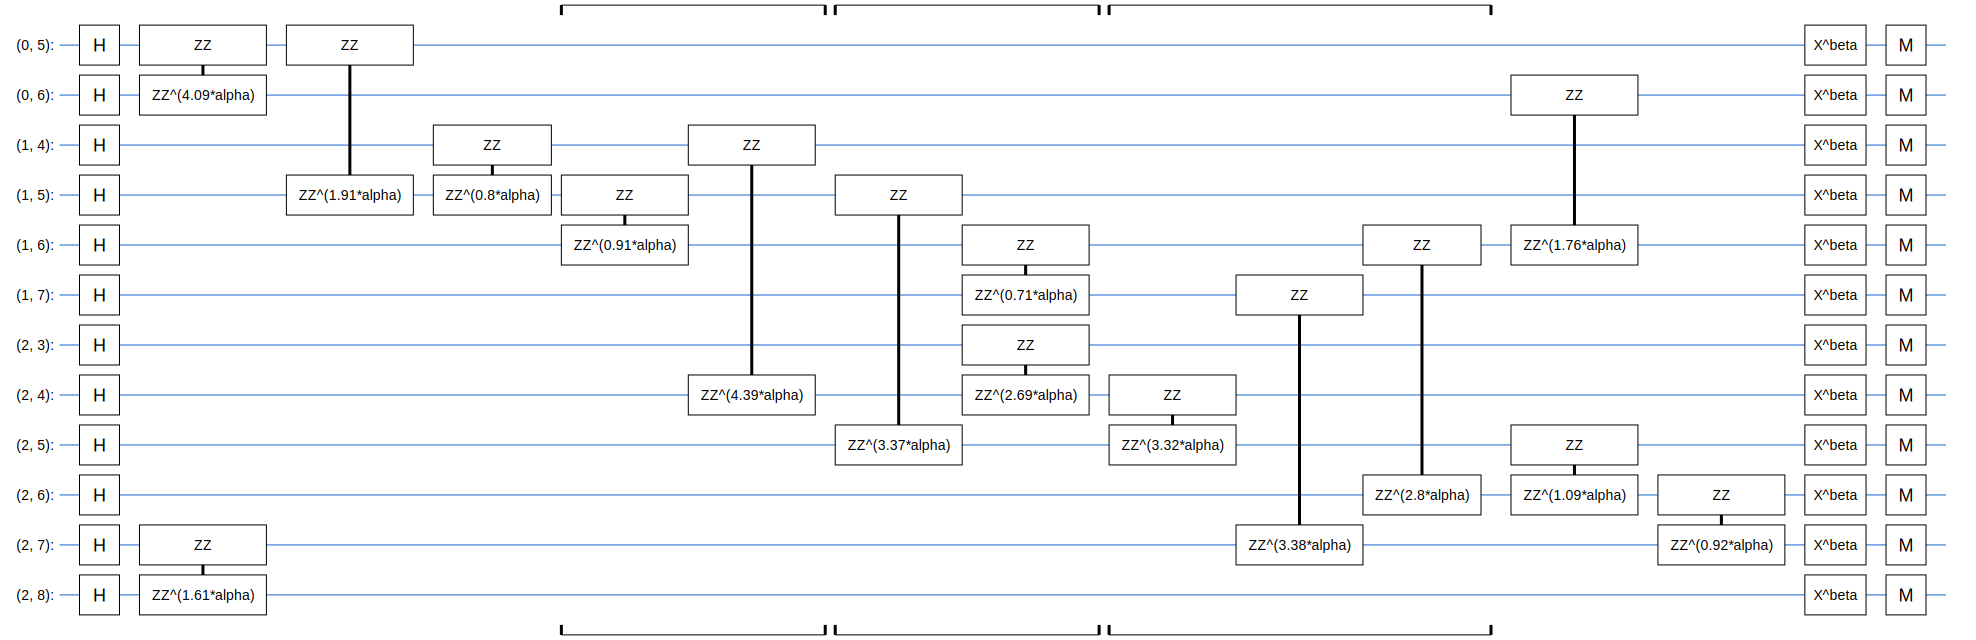

In [20]:
from cirq.contrib.svg import SVGCircuit

# Symbols for the rotation angles in the QAOA circuit.
alpha = sympy.Symbol("alpha")
beta = sympy.Symbol("beta")

qaoa_circuit = cirq.Circuit(
    # Prepare uniform superposition on working_qubits == working_graph.nodes
    cirq.H.on_each(working_graph.nodes()),
    # Do ZZ operations between neighbors u, v in the graph. Here, u is a qubit,
    # v is its neighboring qubit, and w is the weight between these qubits.
    (
        cirq.ZZ(u, v) ** (alpha * w["weight"])
        for (u, v, w) in working_graph.edges(data=True)
    ),
    # Apply X operations along all nodes of the graph. Again working_graph's
    # nodes are the working_qubits. Note here we use a moment
    # which will force all of the gates into the same line.
    cirq.Moment(cirq.X(qubit) ** beta for qubit in working_graph.nodes()),
    # All relevant things can be computed in the computational basis.
    (cirq.measure(qubit) for qubit in working_graph.nodes()),
)
SVGCircuit(qaoa_circuit)


In [21]:
import pandas as pd


def estimate_cost(graph: nx.Graph, samples: pd.DataFrame) -> float:
    """Estimate the cost function of the QAOA on the given graph using the
    provided computational basis bitstrings."""
    cost_value = 0.0

    # Loop over edge pairs and compute contribution.
    for u, v, w in graph.edges(data=True):
        u_samples = samples[str(u)]
        v_samples = samples[str(v)]

        # Determine if it was a +1 or -1 eigenvalue.
        u_signs = (-1) ** u_samples
        v_signs = (-1) ** v_samples
        term_signs = u_signs * v_signs

        # Add scaled term to total cost.
        term_val = np.mean(term_signs) * w["weight"]
        cost_value += term_val

    return -cost_value

In [22]:
alpha_value = np.pi / 4
beta_value = np.pi / 2
sim = cirq.Simulator()

sample_results = sim.sample(
    qaoa_circuit, params={alpha: alpha_value, beta: beta_value}, repetitions=20_000
)
print(f"Alpha = {round(alpha_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(working_graph, sample_results)}")


Alpha = 0.785 Beta = 1.571
Estimated cost: 1.790991


In [23]:
sample_results

alpha      beta  (0, 5)  (1, 5)  (2, 4)  (2, 8)  (1, 7)  (2, 6)  \
0      0.785398  1.570796       1       0       0       1       1       1   
1      0.785398  1.570796       1       0       0       0       0       0   
2      0.785398  1.570796       0       0       1       1       1       1   
3      0.785398  1.570796       1       1       1       1       0       1   
4      0.785398  1.570796       0       0       0       1       0       1   
...         ...       ...     ...     ...     ...     ...     ...     ...   
19995  0.785398  1.570796       0       1       0       1       1       1   
19996  0.785398  1.570796       0       0       0       1       1       0   
19997  0.785398  1.570796       1       1       1       0       0       0   
19998  0.785398  1.570796       0       0       1       1       1       0   
19999  0.785398  1.570796       1       0       0       0       0       1   

       (1, 6)  (2, 5)  (1, 4)  (2, 3)  (2, 7)  (0, 6)  
0           1       0       0       0       1       0  
1           0       1       0       0       0       1  
2           1       0       1       1       0       0  
3           0       1       1       1       1       0  
4           0       1       0       1       0       1  
...       ...     ...     ...     ...     ...     ...  
19995       0       1       1       0       1       1  
19996       0       0       1       0       0       0  
19997       1       1       0       1       0       1  
19998       1       1       1       1       0       0  
19999       1       1       1       1       0       1  

[20000 rows x 14 columns]

In [29]:
for u, v, w in working_graph.edges(data=True):
    print(u,v ,w)

(0, 5) (0, 6) {'directed': False, 'weight': 4.09}
(0, 5) (1, 5) {'directed': False, 'weight': 1.91}
(1, 5) (1, 4) {'directed': False, 'weight': 0.8}
(1, 5) (1, 6) {'directed': False, 'weight': 0.91}
(1, 5) (2, 5) {'directed': False, 'weight': 3.37}
(2, 4) (1, 4) {'directed': False, 'weight': 4.39}
(2, 4) (2, 3) {'directed': False, 'weight': 2.69}
(2, 4) (2, 5) {'directed': False, 'weight': 3.32}
(2, 8) (2, 7) {'directed': False, 'weight': 1.61}
(1, 7) (1, 6) {'directed': False, 'weight': 0.71}
(1, 7) (2, 7) {'directed': False, 'weight': 3.38}
(2, 6) (1, 6) {'directed': False, 'weight': 2.8}
(2, 6) (2, 5) {'directed': False, 'weight': 1.09}
(2, 6) (2, 7) {'directed': False, 'weight': 0.92}
(1, 6) (0, 6) {'directed': False, 'weight': 1.76}


In [61]:
((-1) ** sample_results[str((0, 5))])

0       -1
1       -1
2        1
3       -1
4        1
        ..
19995    1
19996    1
19997   -1
19998    1
19999   -1
Name: (0, 5), Length: 20000, dtype: int64

In [62]:
((-1) ** sample_results[str((0, 6))])

0        1
1       -1
2        1
3        1
4       -1
        ..
19995   -1
19996    1
19997   -1
19998    1
19999   -1
Name: (0, 6), Length: 20000, dtype: int64

In [63]:
 ((-1) ** sample_results[str((0, 5))]) * ((-1) ** sample_results[str((0, 6))])

0       -1
1        1
2        1
3       -1
4       -1
        ..
19995   -1
19996    1
19997    1
19998    1
19999    1
Length: 20000, dtype: int64